# Baseline Model: XGBoost
In this notebook, we forecast the fastest Bitcoin transaction fee (sats/vByte) using XGBoost Regressor. 

### Why We Chose XGBoost as a Baseline Model
We selected XGBoost as one of our baseline models because it provides a strong balance between performance, interpretability, and efficiency when working with structured tabular data. Unlike traditional linear models, XGBoost can effectively capture non-linear relationships and complex interactions between features, which includes both temporal patterns (via lag features) and contextual signals (like mempool and market conditions). 

Our target variable recommended_fee_fastestFee is not only time-dependent but also correlates with other recommended fee rates (e.g., halfHourFee, hourFee, etc.), which serve as important external features. When there are known correlations between the target and input features in the presence of redundancy or nonlinearity, XGBoost offers both high performance and interpretability. The exploratory data analysis confirms these relationships and reveals substantial variability and temporal structure in the data, which makes simpler linear models less effective. XGBoost, in contrast, is robust to multicollinearity, handles missing data gracefully, and naturally incorporates lag features. Additionally, it provides useful feature importance insights and performs well with minimal preprocessing, which makes it a practical and reliable starting point for benchmarking more complex forecasting models.

By tuning key hyperparameters and evaluating the model with MAE and RMSE, we can gauge how well tree-based methods handle fee rate prediction and set a meaningful performance benchmark.


### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib  
from scipy.stats import uniform, randint
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import seaborn as sns
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split, ForecastingRandomizedSearchCV
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_error as mean_absolute_error_sktime
from sktime.split import SlidingWindowSplitter

In [ ]:
import sys
sys.path.append("../src")
from XGBoost import data_split, build_random_search, create_lag_features_fast
from preprocess_raw_parquet import preprocess_raw_parquet

### Load data
To ensure that we only train on complete data, we drop the lag rows which contain NaN values introduced by lag feature creation. Because of spikes in the last day, we remove the last 24-hour from the dataset.

In [3]:
df = preprocess_raw_parquet("../data/raw/mar_5_may_12.parquet")
df.dropna(inplace = True)
df.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create lag features

We will need lagging feature for XGboost. Since each hour has 4 data points (60 ÷ 15), 48 hours = 192 lag steps.

In [ ]:
lags = range(1, 193)  # 48 hours of 15-minute intervals
df = create_lag_features_fast(df, 'recommended_fee_fastestFee', lags)
df.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,recommended_fee_fastestFee_lag_183,recommended_fee_fastestFee_lag_184,recommended_fee_fastestFee_lag_185,recommended_fee_fastestFee_lag_186,recommended_fee_fastestFee_lag_187,recommended_fee_fastestFee_lag_188,recommended_fee_fastestFee_lag_189,recommended_fee_fastestFee_lag_190,recommended_fee_fastestFee_lag_191,recommended_fee_fastestFee_lag_192
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,2.000000,2.000000,2.000000,2.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Optimization - Find the best params

### Params
We choose RandomizedSearch to optimize the model. It allows us to explore a broader space efficiently with fewer iterations. Here are the ranges of parameters.

n_estimators: [50, 100, 150] 
It controls the number of boosting rounds. Small values (50) may underfit, while higher values (150) may lead to better performance but risk overfitting. Keeping this modest helps reduce training time and keeps the search space focused.

max_depth: [1, 2, 3] 
It controls the maximum depth of individual trees. Shallow trees (1–3) are less likely to overfit and are more interpretable. Especially appropriate when the number of features is high and the time resolution is short (5-min data), helping avoid overly complex trees.

learning_rate: [0.01, 0.05, 0.1] 
Learning rate shrinks the contribution of each tree. Lower values slow down learning but improve generalization. Chosen to strike a balance between convergence speed and model stability.

subsample: [0.6, 0.8, 0.9] 
Fraction of rows used per tree. It introduces randomness ,helping prevent overfitting and improving robustness. 0.6–0.9 allows experimentation with more regularized models.

colsample_bytree: [0.6, 0.8, 0.9] 
Fraction of columns (features) used to build each tree. Especially helpful when there are many features. It helps prevent overfitting by decorrelating trees.

gamma: [1, 3, 5] 
Minimum loss reduction to make a split. It acts as a regularizer to control tree growth. Higher values force the model to make only meaningful splits.

reg_lambda: [5, 10, 20] 
L2 regularization on leaf weights. It prevents overly large weights, stabilizing the model especially with correlated features. It also helps handle multicollinearity and improve generalization.

reg_alpha: [5, 10, 20] 
L1 regularization (sparsity). It encourages feature selection by zeroing out less useful ones, and is particularly useful in high-dimensional datasets (e.g., many lag features).

In [5]:
param_dist = {
    'estimator__n_estimators': [50, 100, 150],
    'estimator__max_depth': [1, 2, 3],
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__subsample': [0.6, 0.8, 0.9],
    'estimator__colsample_bytree': [0.6, 0.8, 0.9],
    'estimator__gamma': [1, 3, 5],
    'estimator__reg_lambda': [5, 10, 20],
    'estimator__reg_alpha': [5, 10, 20]
}


In [6]:
def mae_with_std_penalty(y_true, y_pred, std_weight=1.0):
    base_mae = np.mean(np.abs(y_pred - y_true))

    pred_std = np.std(y_pred)
    true_std = np.std(y_true)

    std_penalty = np.mean(np.abs(pred_std - true_std))

    return base_mae + std_weight * std_penalty

### Sliding window

The dataset contains 10-week data. Use each of the five weeks data to train the model. Fixed-size window helps assess how well model generalizes across changing conditions.

In [7]:
y_pred_sliding = {}
# fh 
fh = ForecastingHorizon(np.arange(1, 97), is_relative=True)

avg_mae = 0
avg_rmse = 0
avg_mape = 0
avg_mae_std = 0

base_avg_mae = 0
base_avg_rmse = 0
base_avg_mape = 0
base_avg_mae_std = 0

for i in range(10):
    print("Week",(i+1))
    df_sliding = df[0+i*7*96:7*96+i*7*96]
    X_train, X_test, y_train, y_test = data_split(df_sliding,15)
    random_search = build_random_search(y_train, param_dist,15,1)
    random_search.fit(X=X_train, y=y_train,fh=fh)
    best_forecaster = random_search.best_forecaster_
    # print("Best parameters (MAE):", random_search.best_params_)
    
    y_pred_temp = best_forecaster.predict(fh=fh,X=X_test)
    y_pred_temp.index =X_test.index
    y_pred_sliding[i] = y_pred_temp

    y_baseline = [y_train.median()] * len(y_test)

    mae = mean_absolute_error(y_test, y_pred_temp)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))
    mape = mean_absolute_percentage_error(y_test, y_pred_temp)
    mae_std = mae_with_std_penalty(y_test, y_pred_temp)

    base_mae = mean_absolute_error(y_test, y_baseline)
    base_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))
    base_mape = mean_absolute_percentage_error(y_test, y_baseline)   
    base_mae_std = mae_with_std_penalty(y_test, y_baseline)

    avg_mae += mae
    avg_rmse += rmse
    avg_mape += mape
    avg_mae_std += mae_std
    
    base_avg_mae += base_mae
    base_avg_rmse += base_rmse
    base_avg_mape += base_mape
    base_avg_mae_std += base_mae_std
    print(f"Baseline MAE: {base_mae:.4f}")
    print(f"Baseline RMSE: {base_rmse:.4f}")
    print(f"Baseline MAPE: {base_mape:.4f}")
    print(f"Baseline MAE with std penelty: {base_mae_std:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE with std penelty: {mae_std:.4f}")

avg_mae /= 10
avg_rmse /= 10
avg_mape /= 10
avg_mae_std /= 10

base_avg_mae /= 10
base_avg_rmse /= 10
base_avg_mape /= 10
base_avg_mae_std /= 10

print("\n")
print("Average values: ")
print(f"MAE: {avg_mae:.4f}")
print(f"RMSE: {avg_rmse:.4f}")
print(f"MAPE: {avg_mape:.4f}")
print(f"MAE with std penelty: {avg_mae_std:.4f}")
print(f"Baseline MAE: {base_avg_mae:.4f}")
print(f"Baseline RMSE: {base_avg_rmse:.4f}")
print(f"Baseline MAPE: {base_avg_mape:.4f}")
print(f"Baseline MAE with std penelty: {base_avg_mae_std:.4f}")

Week 1
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Baseline MAE: 1.4306
Baseline RMSE: 2.4995
Baseline MAPE: 0.2715
Baseline MAE with std penelty: 3.6626
MAE: 1.4245
RMSE: 2.4499
MAPE: 0.2815
MAE with std penelty: 3.6196
Week 2
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Baseline MAE: 0.6632
Baseline RMSE: 0.8627
Baseline MAPE: 0.2271
Baseline MAE with std penelty: 1.5182
MAE: 0.6461
RMSE: 0.8681
MAPE: 0.2147
MAE with std penelty: 1.4080
Week 3
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Baseline MAE: 5.3958
Baseline RMSE: 10.4472
Baseline MAPE: 0.4088
Baseline MAE with std penelty: 14.5536
MAE: 13.9678
RMSE: 16.3118
MAPE: 3.1395
MAE with std penelty: 14.4679
Week 4
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Baseline MAE: 0.8021
Baseline RMSE: 0.9724
Baseline MAPE: 0.4068
Baseline MAE with std penelty: 1.7685
MAE: 0.8340
RMSE: 1.0696
MAPE: 0.3548
MAE with std penelty: 1.6589
Week 5
Fitting 3 folds for each of 20 candi

### Plot 

We plot the predicted fee rates and the actual ones. 

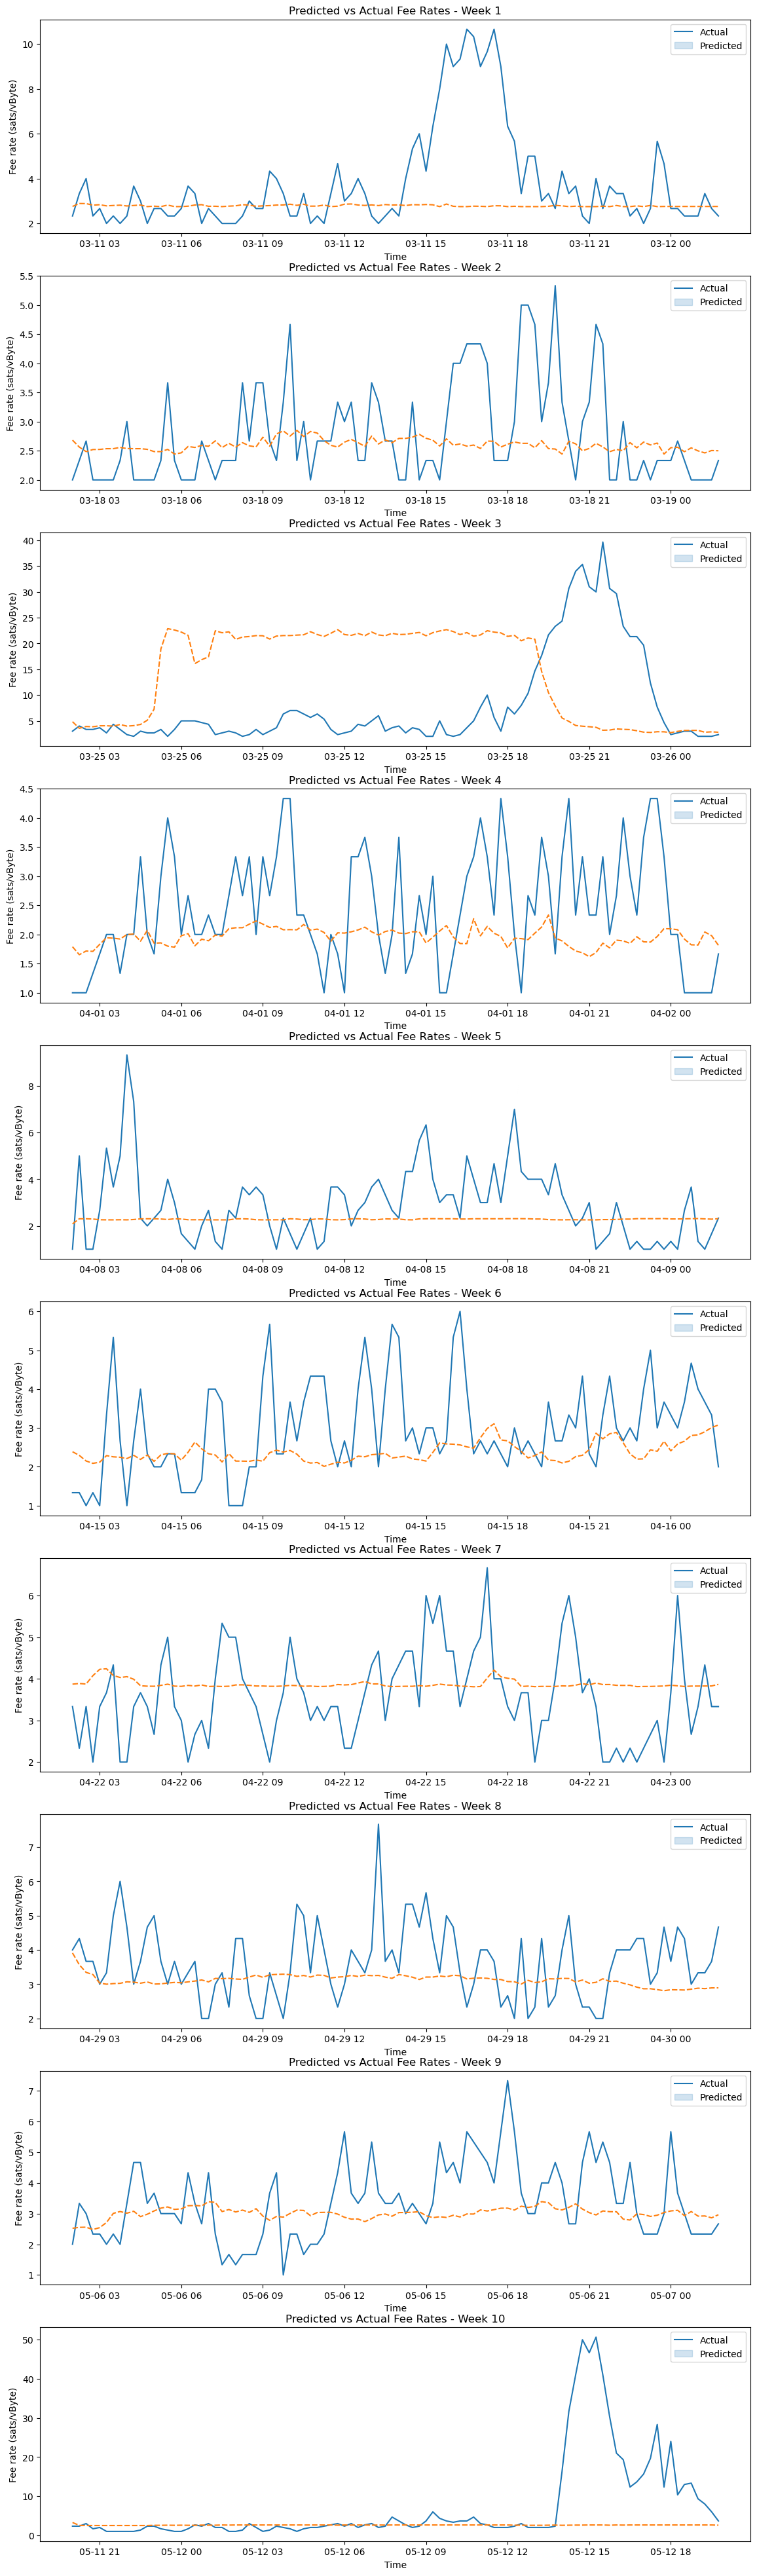

In [8]:
# plot
fig_sliding, axes_sliding = plt.subplots(nrows=10, ncols=1,figsize=(14, 50))

axes_sliding = axes_sliding.flatten()
for i in range(10):

    df_sliding = df[0+i*7*96:7*96+i*7*96]
    X_train, X_test, y_train, y_test = data_split(df_sliding,15)
    # plot
    result_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred_sliding[i]
    }, index=y_test.index)
    sns.lineplot(data=result_df, ax=axes_sliding[i])
    axes_sliding[i].set_title(f'Predicted vs Actual Fee Rates - Week {i+1}')
    axes_sliding[i].set_xlabel('Time')
    axes_sliding[i].set_ylabel('Fee rate (sats/vByte)')
    axes_sliding[i].legend(['Actual', 'Predicted'])


## Expanding window

The dataset contains 10-week data. Start with the first week and train the model five times by progressively adding one more week each time. This methods simulates real-world scenario as more historical data becomes available and tests whether model improves as it learns from a growing dataset. 

In [9]:
y_pred_expanding = {}
# fh 
fh = ForecastingHorizon(np.arange(1, 97), is_relative=True)

avg_mae = 0
avg_rmse = 0
avg_mape = 0

base_avg_mae = 0
base_avg_rmse = 0
base_avg_mape = 0

for i in range(10):
    print((i+1),"Weeks")
    df_expanding = df[:7*96+i*7*96]
    X_train, X_test, y_train, y_test = data_split(df_expanding,15)
    random_search = build_random_search(y_train, param_dist,15,0)
    random_search.fit(X=X_train, y=y_train,fh=fh)
    best_forecaster = random_search.best_forecaster_
    print("Best parameters (MAE):", random_search.best_params_)
    
    y_pred_temp = best_forecaster.predict(fh=fh,X=X_test)
    y_pred_temp.index =X_test.index
    y_pred_expanding[i] = y_pred_temp

    y_baseline = [y_train.median()] * len(y_test)
    
    mae = mean_absolute_error(y_test, y_pred_temp)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))
    mape = mean_absolute_percentage_error(y_test, y_pred_temp)
    mae_std = mae_with_std_penalty(y_test, y_pred_temp)

    base_mae = mean_absolute_error(y_test, y_baseline)
    base_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))
    base_mape = mean_absolute_percentage_error(y_test, y_baseline)   
    base_mae_std = mae_with_std_penalty(y_test, y_baseline)

    avg_mae += mae
    avg_rmse += rmse
    avg_mape += mape
    avg_mae_std += mae_std
    
    base_avg_mae += base_mae
    base_avg_rmse += base_rmse
    base_avg_mape += base_mape
    base_avg_mae_std += base_mae_std
    print(f"Baseline MAE: {base_mae:.4f}")
    print(f"Baseline RMSE: {base_rmse:.4f}")
    print(f"Baseline MAPE: {base_mape:.4f}")
    print(f"Baseline MAE with std penelty: {base_mae_std:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE with std penelty: {mae_std:.4f}")

avg_mae /= 10
avg_rmse /= 10
avg_mape /= 10
avg_mae_std /= 10

base_avg_mae /= 10
base_avg_rmse /= 10
base_avg_mape /= 10
base_avg_mae_std /= 10

print("\n")
print("Average values: ")
print(f"MAE: {avg_mae:.4f}")
print(f"RMSE: {avg_rmse:.4f}")
print(f"MAPE: {avg_mape:.4f}")
print(f"MAE with std penelty: {avg_mae_std:.4f}")
print(f"Baseline MAE: {base_avg_mae:.4f}")
print(f"Baseline RMSE: {base_avg_rmse:.4f}")
print(f"Baseline MAPE: {base_avg_mape:.4f}")
print(f"Baseline MAE with std penelty: {base_avg_mae_std:.4f}")

1 Weeks
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Best parameters (MAE): {'estimator__subsample': 0.8, 'estimator__reg_lambda': 5, 'estimator__reg_alpha': 5, 'estimator__n_estimators': 150, 'estimator__max_depth': 1, 'estimator__learning_rate': 0.01, 'estimator__gamma': 3, 'estimator__colsample_bytree': 0.6}
Baseline MAE: 1.4306
Baseline RMSE: 2.4995
Baseline MAPE: 0.2715
Baseline MAE with std penelty: 3.6626
MAE: 1.4265
RMSE: 2.4253
MAPE: 0.2882
MAE with std penelty: 3.6317
2 Weeks
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Best parameters (MAE): {'estimator__subsample': 0.8, 'estimator__reg_lambda': 5, 'estimator__reg_alpha': 10, 'estimator__n_estimators': 150, 'estimator__max_depth': 1, 'estimator__learning_rate': 0.01, 'estimator__gamma': 3, 'estimator__colsample_bytree': 0.9}
Baseline MAE: 0.6632
Baseline RMSE: 0.8627
Baseline MAPE: 0.2271
Baseline MAE with std penelty: 1.5182
MAE: 0.7356
RMSE: 0.8654
MAPE: 0.2754
MAE with std penelty: 1.5900
3

python(43162) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best parameters (MAE): {'estimator__subsample': 0.9, 'estimator__reg_lambda': 10, 'estimator__reg_alpha': 10, 'estimator__n_estimators': 50, 'estimator__max_depth': 1, 'estimator__learning_rate': 0.1, 'estimator__gamma': 5, 'estimator__colsample_bytree': 0.6}
Baseline MAE: 1.0069
Baseline RMSE: 1.2981
Baseline MAPE: 0.3152
Baseline MAE with std penelty: 2.2410
MAE: 1.1266
RMSE: 1.4658
MAPE: 0.3144
MAE with std penelty: 2.3551
10 Weeks
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Best parameters (MAE): {'estimator__subsample': 0.9, 'estimator__reg_lambda': 10, 'estimator__reg_alpha': 20, 'estimator__n_estimators': 100, 'estimator__max_depth': 2, 'estimator__learning_rate': 0.1, 'estimator__gamma': 1, 'estimator__colsample_bytree': 0.8}
Baseline MAE: 5.6146
Baseline RMSE: 12.0169
Baseline MAPE: 0.6775
Baseline MAE with std penelty: 16.8270
MAE: 5.6481
RMSE: 12.3132
MAPE: 0.5493
MAE with std penelty: 16.6216


Average values: 
MAE: 2.2310
RMSE: 3.4897
MAPE: 0.4981
MAE with

### Plot 

We plot the predicted fee rates and the actual ones. 

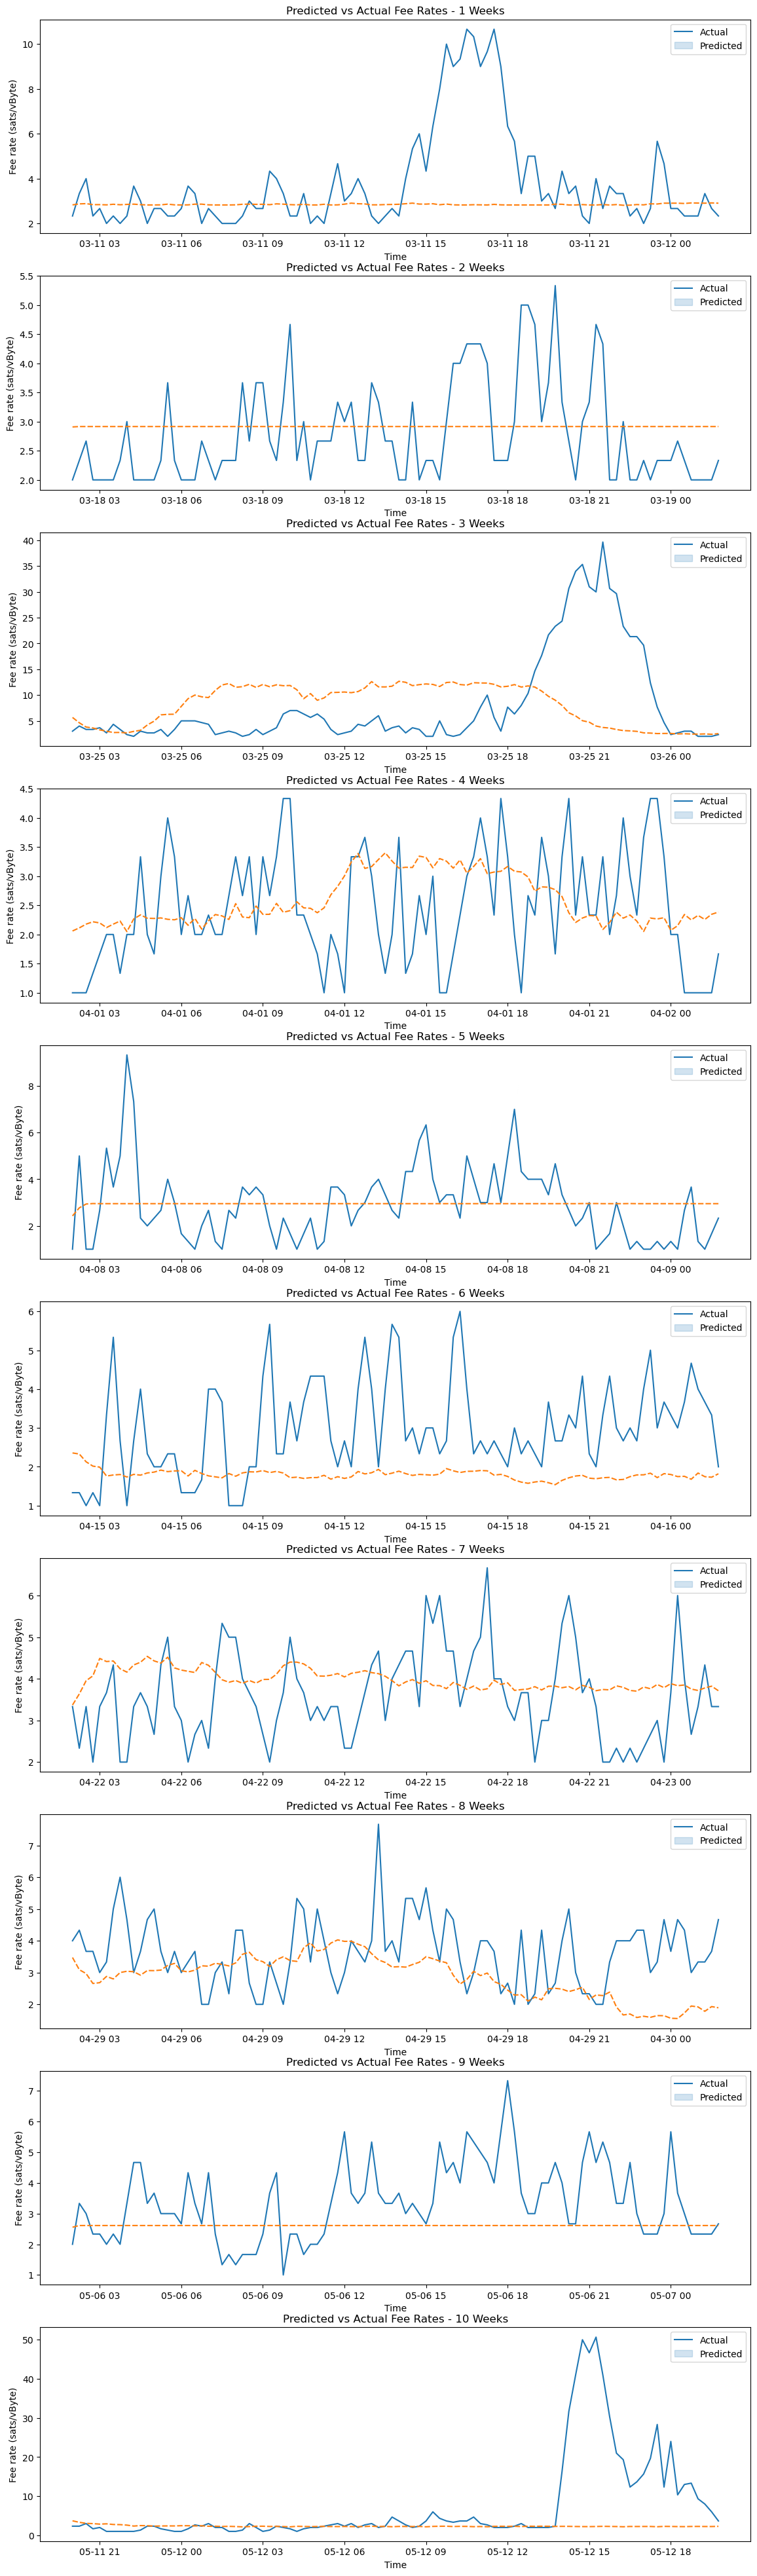

In [10]:
# plot
fig_expanding, axes_expanding = plt.subplots(nrows=10, ncols=1,figsize=(14, 50))

axes_expanding = axes_expanding.flatten()
for i in range(10):
    df_expanding = df[:7*96+i*7*96]
    X_train, X_test, y_train, y_test = data_split(df_expanding,15)
    
    result_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred_expanding[i]
    }, index=y_test.index)
    sns.lineplot(data=result_df, ax=axes_expanding[i])
    axes_expanding[i].set_title(f'Predicted vs Actual Fee Rates - {i+1} Weeks')
    axes_expanding[i].set_xlabel('Time')
    axes_expanding[i].set_ylabel('Fee rate (sats/vByte)')
    axes_expanding[i].legend(['Actual', 'Predicted'])

### The best model

Fianlly, we try to train with expanding window on the whole data set. Because of spikes in the last day, we remove the last 24-hour from the dataset.

In [11]:
df_new = df.iloc[:-96]

In [12]:
X_train, X_test, y_train, y_test = data_split(df_new,15)
random_search = build_random_search(y_train, param_dist,15,0)  # 0 = expanding window
random_search.fit(X=X_train, y=y_train,fh=fh)
best_forecaster = random_search.best_forecaster_
print("Best parameters (MAE):", random_search.best_params_)

y_pred_temp = best_forecaster.predict(fh=fh,X=X_test)
y_pred_temp.index =X_test.index

y_baseline = [y_train.median()] * len(y_test)

mae = mean_absolute_error(y_test, y_pred_temp)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))
mape = mean_absolute_percentage_error(y_test, y_pred_temp)
mae_std = mae_with_std_penalty(y_test, y_pred_temp)

base_mae = mean_absolute_error(y_test, y_baseline)
base_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))
base_mape = mean_absolute_percentage_error(y_test, y_baseline)   
base_mae_std = mae_with_std_penalty(y_test, y_baseline)


Fitting 1 folds for each of 20 candidates, totalling 20 fits
Best parameters (MAE): {'estimator__subsample': 0.9, 'estimator__reg_lambda': 5, 'estimator__reg_alpha': 20, 'estimator__n_estimators': 100, 'estimator__max_depth': 2, 'estimator__learning_rate': 0.1, 'estimator__gamma': 1, 'estimator__colsample_bytree': 0.6}


In [14]:
print(f"Baseline MAE: {base_mae:.4f}")
print(f"Baseline RMSE: {base_rmse:.4f}")
print(f"Baseline MAPE: {base_mape:.4f}")
print(f"Baseline MAE with std penelty: {base_mae_std:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"MAE with std penelty: {mae_std:.4f}")

Baseline MAE: 0.9097
Baseline RMSE: 1.1087
Baseline MAPE: 0.5078
Baseline MAE with std penelty: 1.9095
MAE: 0.7643
RMSE: 1.0452
MAPE: 0.3616
MAE with std penelty: 1.6542


### Plot

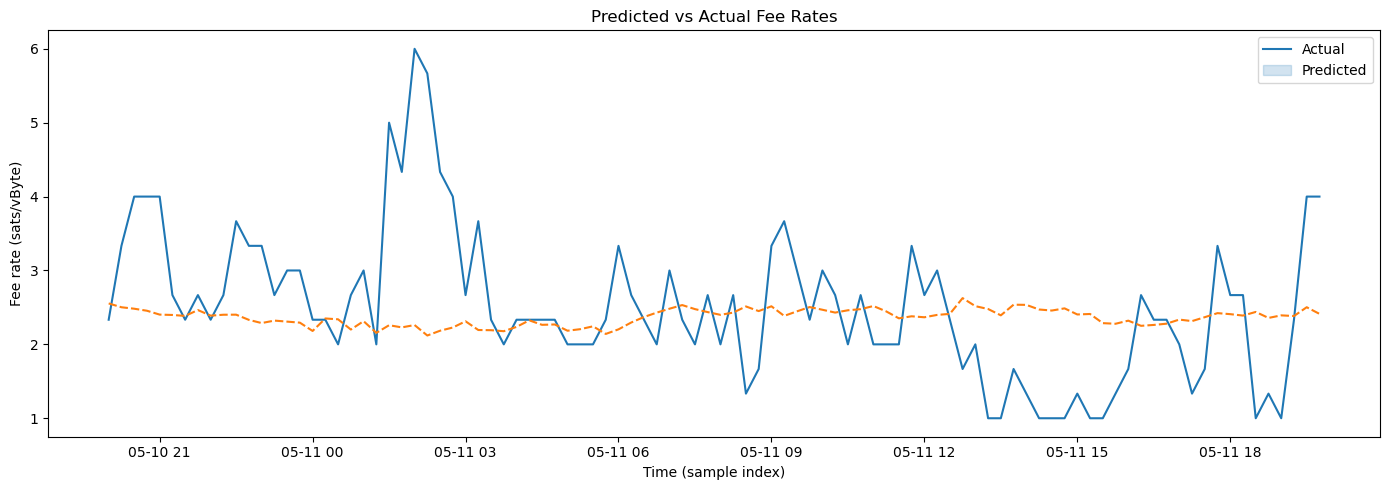

In [13]:
result_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_temp
}, index=y_test.index)

plt.figure(figsize=(14, 5))
sns.lineplot(data=result_df)
plt.title('Predicted vs Actual Fee Rates')
plt.xlabel('Time (sample index)')
plt.ylabel('Fee rate (sats/vByte)')
plt.legend(['Actual', 'Predicted'])
plt.tight_layout()
plt.show()

### Conclusion

Based on the average metrics, expanding window performs better than sliding window across all metrics. Moreover, it slightly outperforms baseline (i.e. global median) within the 5-weeks data available. However, the performance is still far from ideal.